# STM Transit Delay Data Preprocessing

## Overview

This notebook preprocesses data about STM trip updates weather and traffic, data in order to build a regression and classification model that predicts delays in seconds.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`exp_trip_duration`: Expected duration of a trip, in seconds.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`route_direction`: Direction of the trip (Nord, South, West, East).<br>
`arrivals_per_hour`: Number of arrivals per hour for a specific bus line and direction.<br>
`route_type`: Type of bus line (e.g. Night).<br>
`first_stop_id`, `stop_id`, `last_stop_id`: Unique identifier of the first, current and last stop.<br>
`stop_name`: Name of the stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`schedule_relationship`: State of the schedule: "scheduled", "skipped" or "no data".
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`rt_arrival_time`, `rt_departure_time`, `sch_arrival_time`, `sch_departure_time`: Realtime and scheduled times, in UTC.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.<br>
`temperature_2m`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity_2m`: Relative humidity at 2 meters above ground, in percentage.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure_msl`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`wind_speed_10m`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction_10m`: Wind direction at 10 meters above ground.<br>

## Imports

In [1]:
from kneed import KneeLocator
import joblib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from src.constants import LOCAL_TIMEZONE
from src.helper_functions import get_route_bearing

In [3]:
# Load data
df = pd.read_parquet('../data/stm_weather_merged.parquet')
stops_df = pd.read_csv('../data/stops_cleaned.csv')

## Data Preprocessing

### Get historical average delay

Since the volume of data is so large, a big portion of it can be used as "historical data" to calculate the average delay. The rest will be used for modeling.

In [4]:
# Convert scheduled arrival time to local timezone
df['sch_arrival_time'] = df['sch_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)

In [5]:
# Sort data by arrival time
df = df.sort_values(by='sch_arrival_time')

In [6]:
# Get minimum date
min_time = df['sch_arrival_time'].min()
min_time

Timestamp('2025-04-27 17:39:47-0400', tz='Canada/Eastern')

In [7]:
# Get day of week and hour
df['day'] = df['sch_arrival_time'].dt.day_of_week
df['hour'] = df['sch_arrival_time'].dt.hour

In [8]:
# Use half as historical data
index = math.floor(len(df) / 2)
past_df = df.iloc[:index].copy().reset_index(drop=True)
new_df = df.iloc[index:].copy().reset_index(drop=True)

In [9]:
# Calculate average delay by stop and hour
avg_delay_df = past_df.groupby(['route_id', 'stop_id', 'hour'])['delay'].mean().reset_index()
avg_delay_df = avg_delay_df.rename(columns={'delay': 'hist_avg_delay'})

In [10]:
# Export data
avg_delay_df.to_csv('../data/hist_avg_delays.csv', index=False)

In [11]:
# Merge new data with average
df = pd.merge(left=new_df, right=avg_delay_df, how='left', on=['route_id', 'stop_id', 'hour'])

In [12]:
print(df['hist_avg_delay'].isna().sum())

7355


In [13]:
# Fill missing values with overall delay
df['hist_avg_delay'] = df['hist_avg_delay'].fillna(df['delay'].mean())
assert df['hist_avg_delay'].isna().sum() == 0

### Temporal feature extraction

In [14]:
# Convert hour to time of day
ranges = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']

df['time_of_day'] = pd.cut(df['hour'], bins=ranges, labels=labels, include_lowest=True, right=False)
df['time_of_day'].value_counts()

time_of_day
afternoon    1401252
morning      1177623
evening       868414
night         318157
Name: count, dtype: int64

In [15]:
df['day'].value_counts()

day
3    742452
1    711690
2    694951
0    687554
5    487297
6    437098
4      4404
Name: count, dtype: int64

In [16]:
# Add boolean value is_weekend
weekend_mask = df['day'].isin([5, 6])
df['is_weekend'] = weekend_mask.astype('int64')

In [17]:
# Add boolean value is_peak_hour (from 6-9am or 3-6pm)
df['is_peak_hour'] = (~weekend_mask & df['hour'].isin([6, 7, 8, 9, 15, 16, 17, 18])).astype('int64')

### Use One Hot Encoding for categorical columns

In [18]:
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    3668863
Skipped        88838
NoData          7745
Name: count, dtype: int64

In [19]:
# Collapse categories
df['schedule_relationship'] = np.where(df['schedule_relationship'] != 'Scheduled', 'NotScheduled', df['schedule_relationship'])
value_counts = df['schedule_relationship'].value_counts(normalize=True)
value_counts

schedule_relationship
Scheduled       0.97435
NotScheduled    0.02565
Name: proportion, dtype: float64

In [20]:
# Get weights (for prediction)
schedule_rel_weights = value_counts.to_dict()
schedule_rel_weights

{'Scheduled': 0.9743501832186678, 'NotScheduled': 0.025649816781332144}

In [21]:
# Get string columns
string_columns = df.drop(['stop_name', 'route_type', 'route_direction'], axis=1).select_dtypes(include=['object', 'category']).columns
string_columns

Index(['schedule_relationship', 'time_of_day'], dtype='object')

In [22]:
# Use One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = encoder.fit_transform(df[string_columns])
new_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(string_columns))
df = df.drop(columns=string_columns, axis=1).join(new_df)

### Use K-Means to cluster stop coordinates

In [23]:
# Scale coordinates
coords_df = stops_df[['stop_lat', 'stop_lon']]
scaler_coords = StandardScaler()
coords_df_scaled = scaler_coords.fit_transform(coords_df)
coords_df_scaled = pd.DataFrame(coords_df_scaled, columns=scaler_coords.get_feature_names_out())

In [24]:
# Build multiple K-Means models
models = []
for k in range(2, 31):
	kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
	kmeans.fit(coords_df_scaled)
	labels = kmeans.labels_
	models.append({
		'k': k,
		'ssd': kmeans.inertia_,
		'silhouette': silhouette_score(coords_df_scaled, labels, metric='euclidean', random_state=42),
	})

models_df = pd.DataFrame(models).set_index('k')

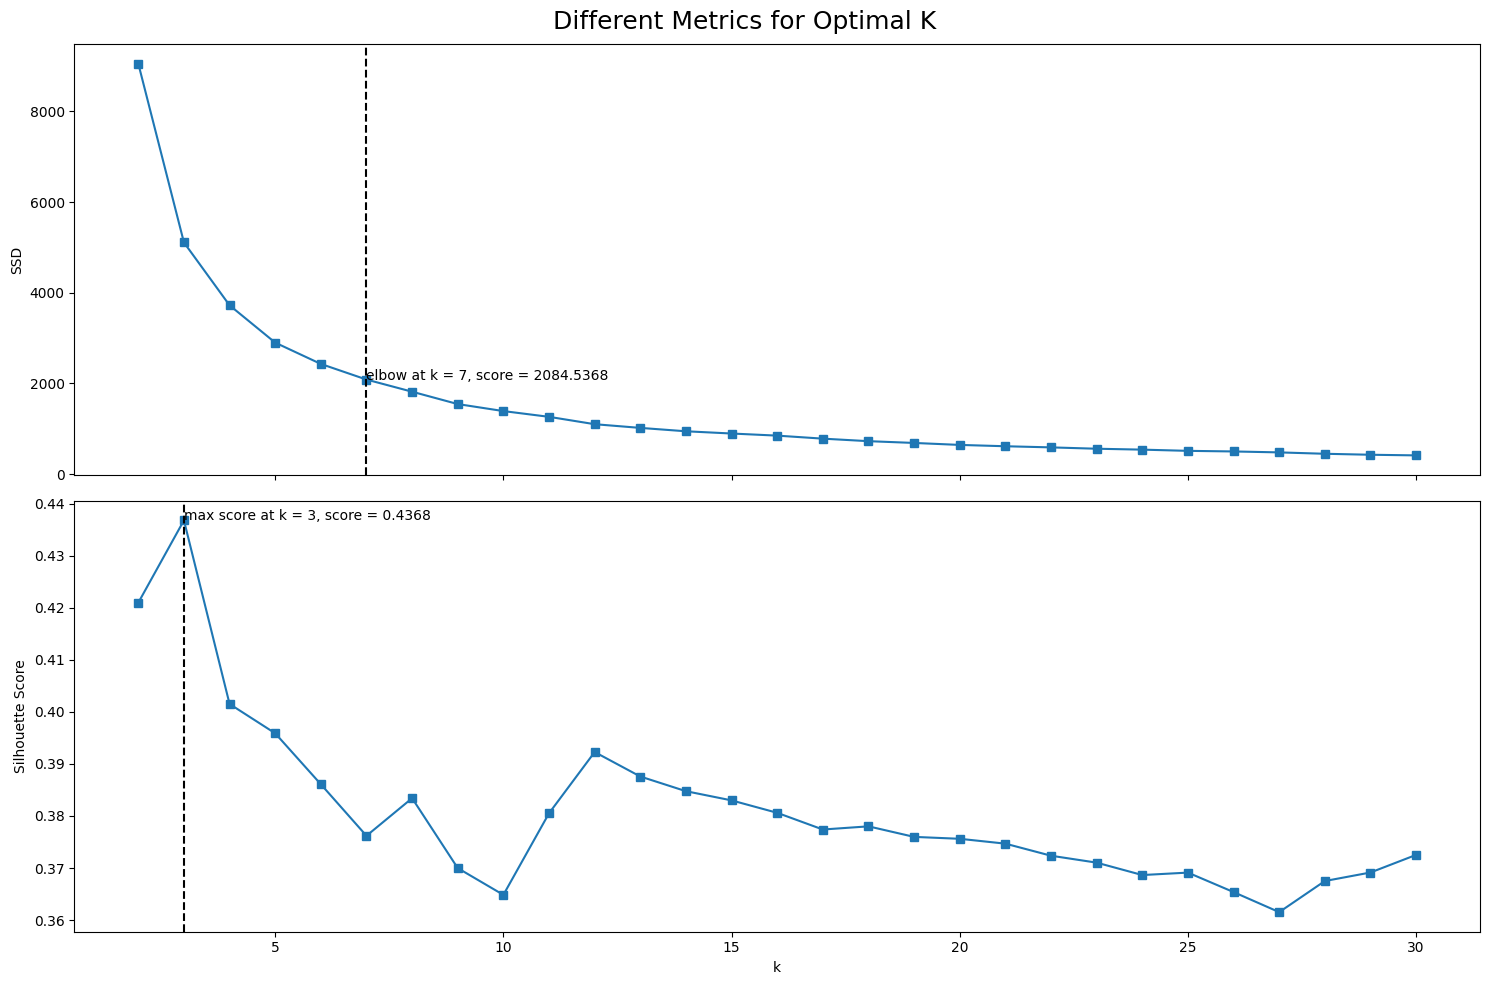

In [25]:
# Display K plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)

# Elbow Method
kneedle = KneeLocator(models_df.index, models_df['ssd'], curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
optimal_score = models_df.loc[optimal_k, 'ssd']
ax1.plot(models_df['ssd'], marker='s')
ax1.set_ylabel('SSD')
ax1.axvline(x=optimal_k, color='black', linestyle='--')
ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

# Silhouette Score
optimal_k = models_df['silhouette'].idxmax()
max_score = models_df['silhouette'].max()
ax2.plot(models_df['silhouette'], marker='s')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.axvline(x=optimal_k, color='black', linestyle='--')
ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

fig.suptitle(f'Different Metrics for Optimal K', fontsize=18)
fig.tight_layout()
fig.savefig('../images/k_means_plots.png', bbox_inches='tight')
plt.show()

In [26]:
# Fit model with optimal k
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(coords_df_scaled)

KMeans(n_clusters=7, random_state=42)

In [27]:
# Add clusters
stops_df.insert(0, 'stop_cluster', kmeans.labels_)

In [28]:
# Export stops with cluster numbers
stops_df.to_csv('../data/stops_with_clusters.csv', index=False)

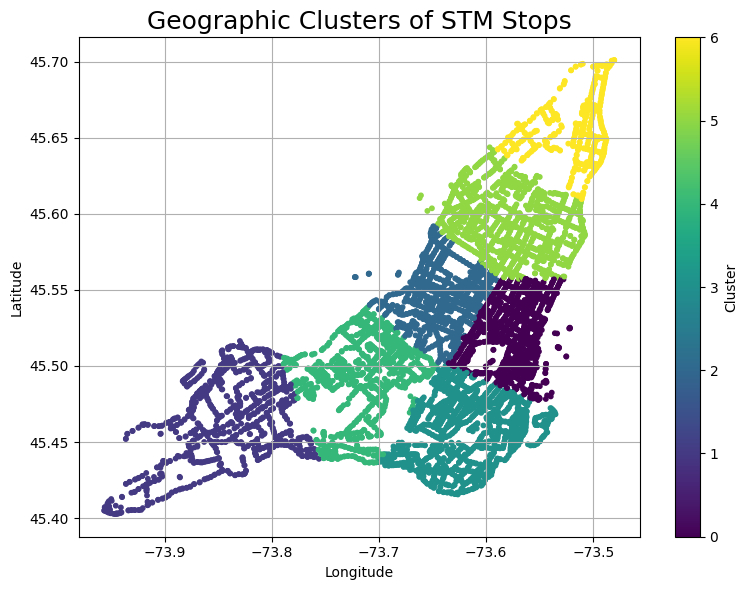

In [29]:
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(x=stops_df['stop_lon'], y=stops_df['stop_lat'], c=stops_df['stop_cluster'], cmap='viridis', s=10)
plt.title('Geographic Clusters of STM Stops', fontsize=18)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/stop_clusters.png', bbox_inches='tight')
plt.show()

In [30]:
# Merge clusters of current stop to dataframe
df = pd.merge(df, stops_df[['stop_id', 'stop_cluster']], how='inner', on='stop_id')

In [31]:
# Merge coordinates of first stop to dataframe
df = pd.merge(df, stops_df[['stop_id', 'stop_lat', 'stop_lon']], how='inner', left_on='first_stop_id', right_on='stop_id', suffixes=[None, '_first']) \
	.drop('stop_id_first', axis=1)

In [32]:
# Merge coordinates of last stop to dataframe
df = pd.merge(df, stops_df[['stop_id', 'stop_lat', 'stop_lon']], how='inner', left_on='last_stop_id', right_on='stop_id', suffixes=[None, '_last']) \
	.drop('stop_id_last', axis=1)

In [33]:
df.columns

Index(['trip_id', 'route_id', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'first_stop_id', 'last_stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon',
       'wheelchair_boarding', 'exp_trip_duration', 'stop_distance',
       'route_direction', 'sch_arrival_time', 'sch_departure_time',
       'arrivals_per_hour', 'delay', 'route_type', 'temperature_2m',
       'relative_humidity_2m', 'precipitation', 'pressure_msl', 'cloud_cover',
       'wind_speed_10m', 'wind_direction_10m', 'day', 'hour', 'hist_avg_delay',
       'is_weekend', 'is_peak_hour', 'schedule_relationship_Scheduled',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'stop_cluster', 'stop_lat_first', 'stop_lon_first', 'stop_lat_last',
       'stop_lon_last'],
      dtype='object')

### Calculate route bearing

In [34]:
# Calculate bearing between first and last stop
df['route_bearing'] = df.apply(lambda row: get_route_bearing(
  row['stop_lon_last'], row['stop_lon_first'],
  row['stop_lat_last'], row['stop_lat_first']), axis=1)
df['route_bearing'].describe()

count    3.765446e+06
mean     1.625087e+02
std      9.791385e+01
min      0.000000e+00
25%      6.447540e+01
50%      1.857244e+02
75%      2.451943e+02
max      3.591853e+02
Name: route_bearing, dtype: float64

### Drop redundant/unnecessary columns


**Columns to drop**

`trip_id`: Identifies a vehicle on a specific day and might cause data leakage.<br>
`route_id`: The route types have been encoded.<br>
`route_direction`: It has been encoded with the first and last stop clusters along with the bearing.<br>
`route_type`: The hourly frequencies have been calculated.<br>
`stop_id`, `first_stop_id`, `last_stop_id` `stop_name`, `stop_lat`, `stop_lon`, `neighbourhood`: The stops are now clustered with K-Means.<br>
`stop_lat_first`, `stop_lon_first`, `stop_lat_last`, `stop_lon_last`: The bearing has been calculated.<br>
`stop_sequence`: There's already the trip progress.<br>
`rt_arrival_time`, `rt_departure_time`, `sch_arrival_time`, `sch_departure_time`, `day`, `hour` : Encoded with time_of_day and is_peak_hour.<br>

In [35]:
df = df.drop([
	'trip_id',
	'route_id',
	'route_direction',
	'route_type',
	'stop_id',
	'first_stop_id',
	'last_stop_id',
  	'stop_lat',
	'stop_lon',
	'stop_lat_first',
  	'stop_lon_first',
    'stop_lat_last',
    'stop_lon_last',
	'stop_name',
	'stop_sequence',
	'rt_arrival_time',
  	'rt_departure_time', 
  	'sch_arrival_time', 
  	'sch_departure_time',
    'day',
    'hour'
  ], axis=1)

In [36]:
# Sort columns in alphabetical order
columns = sorted(df.columns.tolist())
df = df[columns]
df.columns

Index(['arrivals_per_hour', 'cloud_cover', 'delay', 'exp_trip_duration',
       'hist_avg_delay', 'is_peak_hour', 'is_weekend', 'precipitation',
       'pressure_msl', 'relative_humidity_2m', 'route_bearing',
       'schedule_relationship_Scheduled', 'stop_cluster', 'stop_distance',
       'temperature_2m', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'trip_progress', 'wheelchair_boarding',
       'wind_direction_10m', 'wind_speed_10m'],
      dtype='object')

## Export Data

In [37]:
# Make sure there are no null values
assert df.isna().sum().sum() == 0

In [38]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [39]:
# Save useful data
joblib.dump(scaler_coords, '../models/scaler_coords.pkl')
joblib.dump(min_time, '../models/min_time.pkl')
joblib.dump(schedule_rel_weights, '../models/sch_rel_weights.pkl')

['../models/sch_rel_weights.pkl']

In [40]:
# Export dataframe
df.to_parquet('../data/preprocessed.parquet', index=False)

## End